In [1]:
TTS_PATH = "/home/arya/Documents/coquitts/TTS/TTS"

In [2]:
import os
import sys
sys.path.append(TTS_PATH) # set this if TTS is not installed globally
import librosa
import numpy as np
import pandas as pd
from scipy.stats import norm
from tqdm import tqdm_notebook as tqdm
from multiprocessing import Pool
from matplotlib import pylab as plt
from collections import Counter
from TTS.tts.datasets.formatters import *
%matplotlib inline

In [3]:
DATA_PATH = "/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr"
META_DATA = ["te_in_female.tsv",
            "te_in_male.tsv"]
NUM_PROC = 8

In [4]:
# use your own preprocessor at this stage - TTS/datasets/proprocess.py
items = openslr_in(DATA_PATH, META_DATA)
print(" > Number of audio files: {}".format(len(items)))

 > Number of audio files: 4448


In [5]:
# check wavs if exist
wav_files = []
for item in items:
    wav_file = item[1].strip()
    wav_files.append(wav_file)
    if not os.path.exists(wav_file):
        print(waf_path)

In [6]:
# show duplicate items
c = Counter(wav_files)
print([item for item, count in c.items() if count > 1])

[]


In [7]:
def load_item(item):
    file_name = item[1].strip()
    text = item[0].strip()
    audio = librosa.load(file_name, sr=None)
    sr = audio[1]
    audio = audio[0]
    audio_len = len(audio) / sr
    text_len = len(text)
    return file_name, text, text_len, audio, audio_len

# This will take a while depending on size of dataset
if NUM_PROC == 1:
    data = []
    for m in tqdm(items):
        data += [load_item(m)]
else:
    with Pool(8) as p:
        data = list(tqdm(p.imap(load_item, items), total=len(items)))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4448/4448 [00:05<00:00, 802.44it/s]


In [8]:
# count words in the dataset
w_count = Counter()
for item in tqdm(data):
    text = item[1].lower().strip()
    for word in text.split():
        w_count[word] += 1
print(" > Number of words: {}".format(len(w_count)))

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4448/4448 [00:00<00:00, 428761.36it/s]

 > Number of words: 6051


In [9]:
text_vs_durs = {}  # text length vs audio duration
text_len_counter = Counter()  # number of sentences with the keyed length
for item in tqdm(data):
    text = item[1].lower().strip()
    text_len = len(text)
    text_len_counter[text_len] += 1
    audio_len = item[-1]
    try:
        text_vs_durs[text_len] += [audio_len]
    except:
        text_vs_durs[text_len] = [audio_len]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4448/4448 [00:00<00:00, 1019746.61it/s]


In [10]:
# text_len vs avg_audio_len, median_audio_len, std_audio_len
text_vs_avg = {}
text_vs_median = {}
text_vs_std = {}
for key, durs in text_vs_durs.items():
    text_vs_avg[key] = np.mean(durs)
    text_vs_median[key] = np.median(durs)
    text_vs_std[key] = np.std(durs)

### Avg audio length per char

In [11]:
print (list(text_vs_avg.items())[:5])

[(53, 6.295703703703703), (37, 4.664233486943164), (31, 4.511871485943774), (38, 4.688025518341307), (30, 4.100063492063493)]


In [12]:
for item in data:
    if item[-1] < 2:
        print(item)

('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_female/tef_06625_01487098156.wav', 'చదవక తప్పదన్న మాట', 17, array([ 0.        ,  0.        ,  0.        , ..., -0.00073242,
       -0.00082397, -0.00091553], dtype=float32), 1.9626666666666666)
('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_female/tef_06625_02022822442.wav', 'ఇవి సునామీలు కావు', 17, array([0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 6.1035156e-05,
       6.1035156e-05, 9.1552734e-05], dtype=float32), 1.9626666666666666)
('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_female/tef_07789_00619287256.wav', 'ఆంస్ట్రాంగ్ అండ్', 16, array([ 6.1035156e-05,  9.1552734e-05,  1.2207031e-04, ...,
       -3.0517578e-04, -2.1362305e-04, -9.1552734e-05], dtype=float32), 1.8773333333333333)
('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_female/tef_04830_00914011632.wav', 'జనం నోళ్లలో నానలేదు', 19, array([ 0.        ,  0.        ,  0.        , ..., -0.00158691,

In [36]:
sec_per_chars = []
unique_chars = {}
len_texts = []
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    sec_per_chars.append(sec_per_char)
    filtered_sentence = list(filter(lambda x : x != ' ', text))
    for i, k in enumerate(filtered_sentence):
        try:
            unique_chars[k] += 1
        except:
            unique_chars[k] = 1
    len_texts.append(len(text))
# sec_per_char /= len(data)
# print(sec_per_char)
filter_chars = {"pad": "_",
"eos": "&",
"bos": "*",
"characters": "!¡'(),-.:;¿?abcdefghijklmnopqrstuvwxyzµßàáâäåæçèéêëìíîïñòóôöùúûüąćęłńœśşźżƒабвгдежзийклмнопрстуфхцчшщъыьэюяёєіїґӧ «°±µ»$%&‘’‚“`”„",
"punctuations": "!¡'(),-.:;¿? "}
special_unique_chars = {}
for k,v in unique_chars.items():
    k = k.lower()
    knotinj = True
    for i, j in filter_chars.items():
        knotinj = knotinj and k not in j
    if knotinj:
        special_unique_chars[str(k).encode('unicode_escape').decode('utf-8')] = (ord(k), v)
    
print (''.join(special_unique_chars.keys()))

sample_sentence = data[0][1]
print(f'\n{sample_sentence}')
print(str(sample_sentence).encode('unicode_escape').decode('utf-8'))

\u0c08\u0c35\u0c3f\u0c3e\u0c26\u0c02\u0c38\u0c46\u0c2a\u0c4d\u0c1f\u0c2c\u0c30\u0c21\u0c41\u0c47\u0c32\u0c24\u0c4a\u0c2e\u0c28\u0c37\u0c15\u0c48\u0c12\u0c2f\u0c25\u0c20\u0c36\u0c09\u0c1a\u0c17\u0c33\u0c39\u0c4b\u0c42\u0c40\u0c05\u0c1c\u0c2b\\\u0c4c\u0c06\u0c23\u0c27\u0c0f\u0c07\u0c18\u0c16\u0c0e\u0c2d\u200c\u0c13\u0c43\u0c22\u0c0a\u0c10\u0c1b\u0c03\u0c1e\u0c0b\u0c14\u0c31/\u0c19\u0c01

ఈ వివాదం సెప్టెంబర్ రెండు వేల తొమ్మిదిన పరిష్కారమైనది
\u0c08 \u0c35\u0c3f\u0c35\u0c3e\u0c26\u0c02 \u0c38\u0c46\u0c2a\u0c4d\u0c1f\u0c46\u0c02\u0c2c\u0c30\u0c4d \u0c30\u0c46\u0c02\u0c21\u0c41 \u0c35\u0c47\u0c32 \u0c24\u0c4a\u0c2e\u0c4d\u0c2e\u0c3f\u0c26\u0c3f\u0c28 \u0c2a\u0c30\u0c3f\u0c37\u0c4d\u0c15\u0c3e\u0c30\u0c2e\u0c48\u0c28\u0c26\u0c3f


In [37]:
print ('\u0268'.encode('utf-8').decode('unicode_escape'))

É¨


In [38]:
mean = np.mean(sec_per_chars)
std = np.std(sec_per_chars)
print(mean)
print(std)
print(" | > Max length sequence: {}".format(np.max(len_texts)))
print(" | > Min length sequence: {}".format(np.min(len_texts)))
print(" | > Avg length sequence: {}".format(np.mean(len_texts)))

0.136400434800345
0.04820497245593332
 | > Max length sequence: 97
 | > Min length sequence: 9
 | > Avg length sequence: 35.71380395683453


In [39]:
dist = norm(mean, std)

# find irregular instances long or short voice durations
for item in data:
    text = item[1]
    dur = item[-1]
    sec_per_char = dur / len(text)
    
    pdf = norm.pdf(sec_per_char)
    print (sec_per_char, pdf)
    if pdf < 0.39:
        print(item)

0.08855345911949686 0.3973811470356506
0.113009009009009 0.3964029433851937
0.09909677419354838 0.3969882409398626
0.08757894736842105 0.39741525236506886
0.1223111111111111 0.3959693232949259
0.14360975609756096 0.3948495730926254
0.15753846153846154 0.3940223219330425
0.15881481481481483 0.3939427810834465
0.10666666666666667 0.39667918544648223
0.13552941176470587 0.3952951239050299
0.20557575757575758 0.3906007934201263
0.10860606060606061 0.39659638758201454
0.07662585034013605 0.39777279892344547
0.1869206349206349 0.39203341711440043
0.19254700854700854 0.3916151394980913
0.17527927927927928 0.3928607930276045
0.07384615384615384 0.39785599514138353
0.1609142857142857 0.39381058387123924
0.0896 0.3973441039225684
0.09142857142857143 0.3972783442122679
0.10064957264957264 0.396926679622103
0.09173333333333333 0.3972672561752714
0.2888205128205128 0.38264516647554214
('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_female/tef_05994_01945384488.wav', 'తల నామవాచకంగా

0.1611851851851852 0.3937934029644101
0.07876923076923077 0.39770656119173126
0.13024561403508772 0.3955727781345391
0.1500689655172414 0.39447524917022203
0.12614492753623188 0.39578078090840957
0.09634408602150538 0.3970950427078473
0.11815384615384615 0.39616729338890466
0.14222222222222222 0.39492787983337335
0.104 0.39679062387230274
0.07529411764705883 0.3978130390162586
0.09007407407407407 0.39732718163191316
0.1485432098765432 0.39456512268514804
0.14538271604938272 0.3947484311003353
0.11010752688172044 0.39653127357071916
0.06787878787878789 0.3980242690171909
0.10727619047619047 0.3966533221591251
0.22666666666666666 0.38882441130304624
('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_female/tef_06008_00847779060.wav', 'ఊరికి కొద్ది దూరంలో గోదావరి తీరం', 32, array([0.00012207, 0.00012207, 0.00012207, ..., 0.        , 0.        ,
       0.        ], dtype=float32), 7.253333333333333)
0.11093333333333333 0.3964950844139252
0.09517948717948718 0.397139330831062

0.11158974358974359 0.3964661281605797
0.17723076923076922 0.3927256879017952
0.15407407407407409 0.39423506206511794
0.0918974358974359 0.39726127053898286
0.20580392156862745 0.3905824625585426
0.20906666666666665 0.39031820246903526
0.11447154471544715 0.3963370075506129
0.1485432098765432 0.39456512268514804
0.128 0.39568749504326983
0.11946666666666665 0.39610550540339123
0.1216 0.3960036648080596
0.11784126984126984 0.39618190559236066
0.1152 0.39630385426652254
0.11286021505376345 0.39640960459130953
0.16096969696969696 0.3938070718849831
0.09955555555555556 0.3969701509975825
0.10057142857142856 0.39692980031750164
0.10735483870967741 0.3966499743495426
0.1038840579710145 0.3967954057240181
0.09295238095238094 0.39722253818212594
0.13535632183908045 0.3953043912318025
0.10443781094527364 0.3967725194523173
0.1556078431372549 0.394141446189857
0.15515151515151515 0.3941693934235737
0.11894949494949494 0.39612992647564405
0.10429629629629629 0.3967783796142088
0.0828235294117647 

0.149979797979798 0.39448052622111396
0.09508571428571429 0.3971428736709435
0.096 0.3971081833782665
0.09782113821138211 0.3970381049158451
0.2691282051282051 0.384753069417202
('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_male/tem_04771_01791577090.wav', 'వంద మీటర్\u200cలలో', 13, array([0.00012207, 0.00012207, 0.00012207, ..., 0.00021362, 0.00021362,
       0.00021362], dtype=float32), 3.498666666666667)
0.0754108527131783 0.3978095397578283
0.09431578947368421 0.39717183138995077
0.17819607843137253 0.39265832221558444
0.18718279569892474 0.39201419319873565
0.1074567901234568 0.39664563098683764
0.20533333333333334 0.3906202486218304
0.10429629629629629 0.3967783796142088
0.08302702702702702 0.3975695956514659
0.18921739130434784 0.3918641153544652
0.07944827586206896 0.3976851976011376
0.09813333333333332 0.3970259604940463
0.13241379310344828 0.39546015627900494
0.15753846153846154 0.3940223219330425
0.09686486486486487 0.3970750655307227
0.07253333333333334 0

0.1848888888888889 0.392181520519637
0.24137142857142857 0.3874886904810604
('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_male/tem_04272_01126910887.wav', 'ఇక్కడ ముఖ్యమైన పంటలు వరి మొక్కజొన్న', 35, array([0.0000000e+00, 6.1035156e-05, 0.0000000e+00, ..., 1.7089844e-03,
       1.6784668e-03, 1.7089844e-03], dtype=float32), 8.448)
0.3011764705882353 0.38125296790473234
('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_male/tem_00682_01178028163.wav', 'సముద్ర మరియు స్కై', 17, array([ 3.0517578e-05,  3.0517578e-05,  3.0517578e-05, ...,
       -6.1035156e-05, -6.1035156e-05, -6.1035156e-05], dtype=float32), 5.12)
0.18082539682539683 0.3924730347972522
0.09225225225225225 0.3972482923601242
0.13050980392156863 0.3955591530736608
0.1754074074074074 0.3928519669533871
0.10192592592592592 0.39687536867425754
0.22657471264367818 0.3888325139765504
('/home/arya/Documents/coquitts/TTS/datasets/telugu_openslr/te_in_male/tem_04272_00969199719.wav', 'ఈ నెల గణాంకాలు

### Plot Dataset Statistics

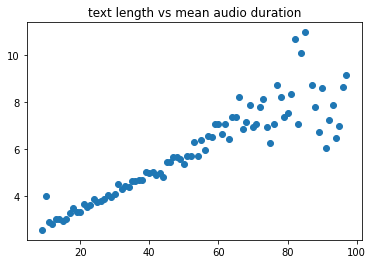

In [40]:
plt.title("text length vs mean audio duration")
plt.scatter(list(text_vs_avg.keys()), list(text_vs_avg.values()))

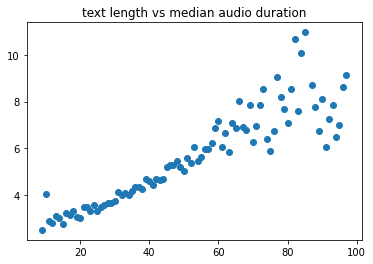

In [38]:
plt.title("text length vs median audio duration")
plt.scatter(list(text_vs_median.keys()), list(text_vs_median.values()))

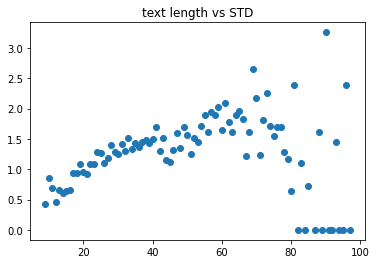

In [17]:
plt.title("text length vs STD")
plt.scatter(list(text_vs_std.keys()), list(text_vs_std.values()))

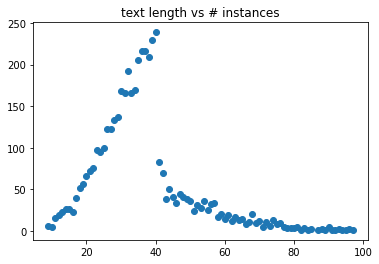

In [39]:
plt.title("text length vs # instances")
plt.scatter(list(text_len_counter.keys()), list(text_len_counter.values()))

### Check words frequencies

In [40]:
w_count_df = pd.DataFrame.from_dict(w_count, orient='index')
w_count_df.sort_values(0, ascending=False, inplace=True)

In [41]:
w_count_df

,0
ఈ,396
ఒక,247
కూడా,182
రెండు,178
ఇది,165
...,...
ప్రాంతానికి,1
శోషరస,1
బహిరంగ,1
వాసన,1


In [44]:
# check a certain word
w_count_df.at['రెండు', 0]

178

In [22]:
# fequency bar plot - it takes time!!
w_count_df.plot.bar()

<AxesSubplot:>

/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3080 (\N{TELUGU LETTER II}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Matplotlib currently does not support Telugu natively.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3090 (\N{TELUGU LETTER O}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3093 (\N{TELUGU LETTER KA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/arya/Documents/coquitts/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3138 (\N{TELUGU VOWEL SIGN UU}) missing from current font.
  fig.canvas.pr

Error in callback <function flush_figures at 0x7f6bd2e93af0> (for post_execute):


KeyboardInterrupt: 

In [30]:
import torch

In [31]:
torch.cuda.current_device()

0

In [32]:
torch.cuda.device(0)

In [33]:
torch.cuda.device_count()

1

In [34]:
torch.cuda.get_device_name(0)

'NVIDIA GeForce GTX 1050 Ti'

In [35]:
torch.cuda.is_available()

True